In [1]:
import requests
from datetime import datetime
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

## FIMA NFIP Redacted Claims - v2 dataset, FEMA
“FIMA NFIP Redacted Claims - v2 | FEMA.gov.” 2023b. Www.fema.gov. 
    July 5, 2023. https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2.

Congress passed the National Flood Insurance Act (NFIA), 42 U.S.C. 4001 in 1968, creating the National Flood Insurance Program (NFIP) in order to reduce future flood losses through flood hazard identification, floodplain management, and providing insurance protection. The Department of Housing and Urban Development (HUD) originally administered the NFIP, and Congress subsequently transferred the NFIP to FEMA upon its creation in 1979. FEMA and insurance companies participating in FEMA's Write Your Own (WYO) program offer NFIP insurance coverage for building structures as well as for contents and personal property within the building structures to eligible and insurable properties. The WYO program began in 1983 with NFIP operating under Part B of the NFIA and allows FEMA to authorize private insurance companies to issue the Standard Flood Insurance Policy (SFIP) as FEMA's fiduciary and fiscal agent. FEMA administers NFIP by ensuring insurance applications are processed properly; determining correct premiums; renewing, reforming, and cancelling insurance policies; transferring policies from the seller of the property to the purchaser of the property in certain circumstances; and processing insurance claims.

The paid premiums of SFIPs and claims payments for damaged property are processed through the National Flood Insurance Fund (NFIF). NFIF was established by the National Flood Insurance Act of 1968 (42 U.S.C. 4001, et seq.), and is a centralized premium revenue and fee-generated fund that supports NFIP, which holds these U.S. Treasury funds.

This dataset provides details on NFIP claims transactions. It is derived from the NFIP system of record, staged in the NFIP reporting platform and redacted to protect policy holder personally identifiable information.

The Flood Insurance Claims Manual (https://nfipservices.floodsmart.gov/insurance-manuals) provides claims guidance to WYOs, vendors, adjusters, and examiners so that policyholders experience consistent and reliable service. The Manual provides processes for handling claims from the notice of loss to final payment. The NFIP has provided answers to Frequently Asked Questions (FAQs) to assist the public in understanding and navigating the data our program makes available: https://www.fema.gov/sites/default/files/documents/fema_nfip-data-faq record.

This dataset is not intended to be an official federal report, and should not be considered an official federal report.

FEMA's terms and conditions and citation requirements for datasets (API usage or file downloads) can be found on the OpenFEMA Terms and Conditions page: https://www.fema.gov/about/openfema/terms-conditions.

In [3]:
# Set the url variable as the NFIP claims url
url = 'https://www.fema.gov/about/reports-and-data/openfema/FimaNfipClaims.csv'

# Send a get request for the url, name the response variable
response = requests.get(url)

# Check if get request request (response) was successful (status code 200)
if response.status_code == 200:
    
    # Specify the file path to save the downloaded file
    file_path = 'FimaNfipClaims.csv'
    
    # Write the content of the response to a file
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully.')
    
else:
    print('Failed to download file.')

File downloaded successfully.


In [5]:
# Read the full file, create a variable.
# I've been dividing my dataframes by state, but just in case I want the full thing, it's accessible.
# Given the size of these files, I usually read them with low_memory set to False.

nfip_all = pd.read_csv('FimaNfipClaims.csv', low_memory = False)

In [7]:
# This was my first time with the nfip dataset, so before I even filtered by state, I decided to check out what national data since 2016 looked like.
# As I was culling my dataframe, I simplified the variable name

nfip = nfip_all[nfip_all['yearOfLoss'] > 2016]

# At this point I decided to filter for Florida, as I was interested particularly in data reflective of climate change.

# Filter for Fla. data only.
# And just to be sure I didn't overlook something in my filter coding, I check the unique values in the state column.

nfip = nfip[nfip['state'] == 'FL']
nfip.state.unique()

array(['FL'], dtype=object)

In [9]:
# Nice! Only Florida claims. (At least according to the 'state' column.)
# I decided to check the columns first to drop what I knew I wouldn't need.

nfip.columns

Index(['agricultureStructureIndicator', 'asOfDate',
       'basementEnclosureCrawlspaceType', 'policyCount',
       'crsClassificationCode', 'dateOfLoss', 'elevatedBuildingIndicator',
       'elevationCertificateIndicator', 'elevationDifference',
       'baseFloodElevation', 'ratedFloodZone', 'houseWorship',
       'locationOfContents', 'lowestAdjacentGrade', 'lowestFloorElevation',
       'numberOfFloorsInTheInsuredBuilding', 'nonProfitIndicator',
       'obstructionType', 'occupancyType', 'originalConstructionDate',
       'originalNBDate', 'amountPaidOnBuildingClaim',
       'amountPaidOnContentsClaim',
       'amountPaidOnIncreasedCostOfComplianceClaim',
       'postFIRMConstructionIndicator', 'rateMethod',
       'smallBusinessIndicatorBuilding', 'totalBuildingInsuranceCoverage',
       'totalContentsInsuranceCoverage', 'yearOfLoss',
       'primaryResidenceIndicator', 'buildingDamageAmount',
       'buildingDeductibleCode', 'netBuildingPaymentAmount',
       'buildingPropertyValu

In [11]:
# This data cleaning was for a school project with specific needs. I knew I wouldn't need these fields.

columns_to_drop = [
    'asOfDate', 'reportedCity', 'reportedZipCode', 'amountPaidOnIncreasedCostOfComplianceClaim', 'rateMethod', 'ficoNumber','latitude', 'longitude', 'id'
]

nfip = nfip.drop(columns = columns_to_drop)

# Check shape
nfip.shape

(188403, 64)

In [13]:
# Now I prep a dictionary of Florida counties for the county_name column I'll make

florida_county_map = {
    '12001': 'Alachua',
    '12003': 'Baker',
    '12005': 'Bay',
    '12005': 'Bay',
    '12007': 'Bradford',
    '12009': 'Brevard',
    '12011': 'Broward',
    '12013': 'Calhoun',
    '12015': 'Charlotte',
    '12017': 'Citrus',
    '12019': 'Clay',
    '12021': 'Collier',
    '12023': 'Columbia',
    '12025': 'Dade',
    '12027': 'DeSoto',
    '12029': 'Dixie',
    '12031': 'Duval',
    '12033': 'Escambia',
    '12035': 'Flagler',
    '12037': 'Franklin',
    '12039': 'Gadsden',
    '12041': 'Gilchrist',
    '12043': 'Glades',
    '12045': 'Gulf',
    '12047': 'Hamilton',
    '12049': 'Hardee',
    '12051': 'Hendry',
    '12053': 'Hernando',
    '12055': 'Highlands',
    '12057': 'Hillsborough',
    '12059': 'Holmes',
    '12061': 'Indian River',
    '12063': 'Jackson',
    '12065': 'Jefferson',
    '12067': 'Lafayette',
    '12069': 'Lake',
    '12071': 'Lee',
    '12073': 'Leon',
    '12075': 'Levy',
    '12077': 'Liberty',
    '12079': 'Madison',
    '12081': 'Manatee',
    '12083': 'Marion',
    '12085': 'Martin',
    '12086': 'Miami Dade',
    '12087': 'Monroe',
    '12089': 'Nassau',
    '12091': 'Okaloosa',
    '12093': 'Okeechobee',
    '12095': 'Orange',
    '12097': 'Osceola',
    '12099': 'Palm Beach',
    '12101': 'Pasco',
    '12103': 'Pinellas',
    '12105': 'Polk',
    '12107': 'Putnam',
    '12109': 'St. Johns',
    '12111': 'St. Lucie',
    '12113': 'Santa Rosa',
    '12115': 'Sarasota',
    '12117': 'Seminole',
    '12119': 'Sumter',
    '12121': 'Suwannee',
    '12123': 'Taylor',
    '12125': 'Union',
    '12127': 'Volusia',
    '12129': 'Wakulla',
    '12131': 'Walton',
    '12133': 'Washington'
}

In [15]:
# Create the new column and get a look at how the FIPS codes are formatted

nfip['county_name'] = ''
nfip.countyCode

7          12021.0
10         12086.0
11         12021.0
12         12081.0
13         12021.0
            ...   
1128013    12011.0
1128060    12011.0
1128217    12087.0
1135986    12031.0
1156291    12011.0
Name: countyCode, Length: 188403, dtype: float64

In [17]:
# First I convert the FIPS codes from floats to strings

nfip['countyCode'] = nfip['countyCode'].astype(str)

In [19]:
# Then I get rid of the '.0' at the end of each string value

nfip['countyCode'] = nfip['countyCode'].apply(lambda x: x.replace('.0', '') if isinstance(x, str) and x.endswith('.0') else x)

In [21]:
# Now I can use my Florida county dictionary to apply county names in my new column based on existing FIPS

nfip['county_name'] = nfip.apply(
    lambda row: florida_county_map.get(row['countyCode'], row['county_name']),
    axis = 1
)

# Preview what the dataset looks like now
nfip.head()

,agricultureStructureIndicator,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,...,stateOwnedIndicator,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,countyCode,censusTract,censusBlockGroupFips,county_name
7,0,0.0,1,NaN,2017-09-10T00:00:00.000Z,1,2,NaN,NaN,VE,...,0,1.0,NaN,1.0,0,FL,12021,1.202101e+10,1.202101e+11,Collier
10,0,0.0,1,NaN,2020-05-26T00:00:00.000Z,1,NaN,1.0,7.0,AH,...,0,0.0,AHB,1.0,0,FL,12086,1.208600e+10,1.208600e+11,Miami Dade
11,0,0.0,1,NaN,2017-09-11T00:00:00.000Z,0,NaN,NaN,NaN,AH,...,0,0.0,NaN,1.0,0,FL,12021,1.202101e+10,1.202101e+11,Collier
12,0,0.0,1,NaN,2020-11-11T00:00:00.000Z,1,NaN,5.0,9.0,AE,...,0,0.0,NaN,1.0,0,FL,12081,1.208100e+10,1.208100e+11,Manatee
13,0,0.0,1,NaN,2022-09-27T00:00:00.000Z,1,NaN,NaN,NaN,AE,...,0,0.0,NaN,NaN,0,FL,12021,1.202101e+10,1.202101e+11,Collier


In [23]:
# Not bad. Now let's change the camelCase column names to snake_case.
# Aesthetically I'm more into camelCase than snake_case, but once I load this in Tableau,
# Tableau recognizes underscores should be spaces, which in turn makes camelCase look messy.

def camel_to_snake(name):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

nfip.columns = [camel_to_snake(col) for col in nfip.columns]

# As always, check how the columns come out.
nfip.columns

Index(['agriculture_structure_indicator', 'basement_enclosure_crawlspace_type',
       'policy_count', 'crs_classification_code', 'date_of_loss',
       'elevated_building_indicator', 'elevation_certificate_indicator',
       'elevation_difference', 'base_flood_elevation', 'rated_flood_zone',
       'house_worship', 'location_of_contents', 'lowest_adjacent_grade',
       'lowest_floor_elevation', 'number_of_floors_in_the_insured_building',
       'non_profit_indicator', 'obstruction_type', 'occupancy_type',
       'original_construction_date', 'original_n_b_date',
       'amount_paid_on_building_claim', 'amount_paid_on_contents_claim',
       'post_f_i_r_m_construction_indicator',
       'small_business_indicator_building',
       'total_building_insurance_coverage',
       'total_contents_insurance_coverage', 'year_of_loss',
       'primary_residence_indicator', 'building_damage_amount',
       'building_deductible_code', 'net_building_payment_amount',
       'building_property_value'

In [25]:
# Now create the columns where I can combine building and contents values

nfip['total_damage'] = ''
nfip['total_coverage'] = ''
nfip['total_payment'] = ''

In [27]:
# First I concatenate damage, from building and contents, making sure to account for nulls

nfip['total_damage'] = nfip['building_damage_amount'].fillna(0) + nfip['contents_damage_amount'].fillna(0)

In [29]:
# I want to get a preview of what I've just made, just to check that I didn't overlook something obvious.

nfip.total_damage.head(10)

7       2396.0
10      4560.0
11         0.0
12      2536.0
13     14227.0
14         0.0
49         0.0
50      4761.0
51    398735.0
52         0.0
Name: total_damage, dtype: float64

In [31]:
# Good! (BTS fact: The first few times I did this, I didn't get a series of numbers that looked this correct.)
# Then I do coverage.

nfip['total_coverage'] = nfip['total_contents_insurance_coverage'].fillna(0) + nfip['total_building_insurance_coverage'].fillna(0)

# And just so I don't get cocky, let's check what that column looks like.
nfip.total_coverage.head(10)

7     300000.0
10    271100.0
11    350000.0
12     13000.0
13     25700.0
14      8500.0
49    350000.0
50    210000.0
51    350000.0
52    350000.0
Name: total_coverage, dtype: float64

In [33]:
# Looking good.
# Now net payments. For the purposes of this project, I call this sum "total_payment".

nfip['total_payment'] = nfip['net_building_payment_amount'].fillna(0) + nfip['net_contents_payment_amount'].fillna(0)
nfip.total_payment.head(10)

7          0.00
10         0.00
11         0.00
12       603.39
13      9802.74
14         0.00
49         0.00
50      8586.18
51    350000.00
52         0.00
Name: total_payment, dtype: float64

In [35]:
# I'm curious about any gap between damage and payment. The lower the value (ideally zero!, maybe sometimes negative), the better off the policy holders are.
# Positive values mean the policy holders didn't get enough money to cover the damage they suffered.

nfip['damage_diff_payment'] = nfip['total_damage'] - nfip['total_payment']

In [37]:
# Do the same check between damage and coverage 

nfip['damage_diff_coverage'] = nfip['total_damage'] - nfip['total_coverage']

# And check how this is calculating in my dataframe
nfip.head()

,agriculture_structure_indicator,basement_enclosure_crawlspace_type,policy_count,crs_classification_code,date_of_loss,elevated_building_indicator,elevation_certificate_indicator,elevation_difference,base_flood_elevation,rated_flood_zone,...,state,county_code,census_tract,census_block_group_fips,county_name,total_damage,total_coverage,total_payment,damage_diff_payment,damage_diff_coverage
7,0,0.0,1,NaN,2017-09-10T00:00:00.000Z,1,2,NaN,NaN,VE,...,FL,12021,1.202101e+10,1.202101e+11,Collier,2396.0,300000.0,0.00,2396.00,-297604.0
10,0,0.0,1,NaN,2020-05-26T00:00:00.000Z,1,NaN,1.0,7.0,AH,...,FL,12086,1.208600e+10,1.208600e+11,Miami Dade,4560.0,271100.0,0.00,4560.00,-266540.0
11,0,0.0,1,NaN,2017-09-11T00:00:00.000Z,0,NaN,NaN,NaN,AH,...,FL,12021,1.202101e+10,1.202101e+11,Collier,0.0,350000.0,0.00,0.00,-350000.0
12,0,0.0,1,NaN,2020-11-11T00:00:00.000Z,1,NaN,5.0,9.0,AE,...,FL,12081,1.208100e+10,1.208100e+11,Manatee,2536.0,13000.0,603.39,1932.61,-10464.0
13,0,0.0,1,NaN,2022-09-27T00:00:00.000Z,1,NaN,NaN,NaN,AE,...,FL,12021,1.202101e+10,1.202101e+11,Collier,14227.0,25700.0,9802.74,4424.26,-11473.0


In [39]:
# How's my shape looking?

nfip.shape

(188403, 70)

In [41]:
# Seems like a lot of rows.
# For this project, building damage is a crucial metric. I may as well exclude any claims that didn't collect that.

nfip.dropna(subset = ['building_damage_amount'], inplace = True)
nfip.shape

(141980, 70)

In [43]:
# That knocked off a chunk.
# Same goes for building coverage.

nfip.dropna(subset = ['total_building_insurance_coverage'], inplace = True)

nfip.shape

(141980, 70)

In [45]:
# Huh. I guess coverage and damage covered the same nulls.

# Contents damage values are also important to my analysis. I wonder how much getting rid of those nulls would eliminate.

nfip.dropna(subset = ['contents_damage_amount'], inplace = True)
nfip.shape

(87298, 70)

In [47]:
# Wow. That's a pretty good shape for this project.
# I'm going to check the columns one more time before I save it as a .csv

nfip.columns

Index(['agriculture_structure_indicator', 'basement_enclosure_crawlspace_type',
       'policy_count', 'crs_classification_code', 'date_of_loss',
       'elevated_building_indicator', 'elevation_certificate_indicator',
       'elevation_difference', 'base_flood_elevation', 'rated_flood_zone',
       'house_worship', 'location_of_contents', 'lowest_adjacent_grade',
       'lowest_floor_elevation', 'number_of_floors_in_the_insured_building',
       'non_profit_indicator', 'obstruction_type', 'occupancy_type',
       'original_construction_date', 'original_n_b_date',
       'amount_paid_on_building_claim', 'amount_paid_on_contents_claim',
       'post_f_i_r_m_construction_indicator',
       'small_business_indicator_building',
       'total_building_insurance_coverage',
       'total_contents_insurance_coverage', 'year_of_loss',
       'primary_residence_indicator', 'building_damage_amount',
       'building_deductible_code', 'net_building_payment_amount',
       'building_property_value'

In [49]:
# I tend to save these by state, so I'll specify FL in the file name.

nfip.to_csv('nfip_florida.csv', index = False)

## Predictive Modeling

### Will flood insurance coverage be insufficient to cover flood damage?

**Objective:** Predict whether damage_diff_coverage is positive.

**Target Variable:** damage_diff_coverage > 0

**Feature Selection:** Exclude irrelevant or redundant columns.

**Handle Missing Values:** Impute or drop rows/columns with missing data.

**Categorical Encoding:** Convert categorical columns to numeric format.

**Feature Scaling:** Standardize or normalize numeric features for better model performance.

**Train-Test Split:** Split the data into training and testing sets.

In [51]:
# First I'll set my target variable

nfip['coverage_insufficient'] = (nfip['damage_diff_coverage'] > 0).astype(int)

In [53]:
# And check what the split is

nfip['coverage_insufficient'].value_counts(normalize = True) * 100

coverage_insufficient
0    94.50732
1     5.49268
Name: proportion, dtype: float64

In [55]:
# Good news for FLorida homeowners; most people who suffered flood damage (at least according to the NFIP database) are sufficiently covered.
# But 5% of 78K people is still worth improving.

# Next in the predictive modeling process, I'll select my features.
# For this preliminary run, I'm going to be pretty inclusive, and just disregard redundant or target-related columns.

target = 'coverage_insufficient'
exclude_columns = ['damage_diff_coverage', 'total_payment', 'total_damage', 'total_coverage']
features = [col for col in nfip.columns if col not in exclude_columns + [target]]

In [57]:
# Now we'll train-test split

X = nfip[features]
y = nfip[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) # my dataset is pretty unbalanced, and my teacher taught me to stratify in such cases

In [59]:
# Next, I'll ID categorical and numeric columns

categorical_cols = X.select_dtypes(include = ['object']).columns
numeric_cols = X.select_dtypes(include = ['float64', 'int64']).columns

In [61]:
# Prime the preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [63]:
# Convert categorical columns to strings to avoid mixed types

for col in categorical_cols:
    nfip[col] = nfip[col].astype(str)

In [65]:
# Fix categorical columns in both train and test sets

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

In [67]:
# OK, trying train-test split again

X = nfip[features]
y = nfip[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [69]:
# Checking that categorical columns are strings throughout
# This is often where I learn some data cleaning lessons

categorical_cols = X.select_dtypes(include = ['object']).columns
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

In [71]:
# Once again, preprocessing!

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with the mean
            ('scaler', StandardScaler())                 # Scale numeric features
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values with the most frequent
            ('encoder', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode categorical variables
        ]), categorical_cols)
    ]
)

In [73]:
# And build the pipeline. This time using RandomForestCLassifier.

model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = 42))
])

In [75]:
# Aaaaaaand let's train the model!

model.fit(X_train, y_train)

C:\Users\natal\anaconda3\Lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['flood_characteristics_indicator']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['agriculture_structure_indicator', 'basement_enclosure_crawlspace_type',
       'policy_count', 'crs_classification_code',
       'elevated_building_indicator', 'elevation_difference',
       'base_flood_elevation', 'house_wor...
       'building_deductible_code', 'cause_of_damage',
       'condominium_coverage_type_code', 'contents_deductible_code',
       'event_designation_number', 'flood_event',
       'nfip_community_number_current', 'nfip_community_name',
       'replacement_cost_basis', 'flood_zone_current', 'state', 'county_code',
       'county_name'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [77]:
# That looks kinda nice.

# Models work to be judged. Let's evaluate this model!

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\natal\anaconda3\Lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['flood_characteristics_indicator']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Accuracy: 0.9683276059564719

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     16501
           1       0.94      0.45      0.61       959

    accuracy                           0.97     17460
   macro avg       0.96      0.72      0.80     17460
weighted avg       0.97      0.97      0.96     17460



In [79]:
# Mmk, pretty good. Not the most realistic model, like we wouldn't have this data to predict sufficiency of flood insurance coverage.
# But it's a good exercise in model generation.

# Generate predictions
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

C:\Users\natal\anaconda3\Lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['flood_characteristics_indicator']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Confusion Matrix:
 [[16475    26]
 [  527   432]]


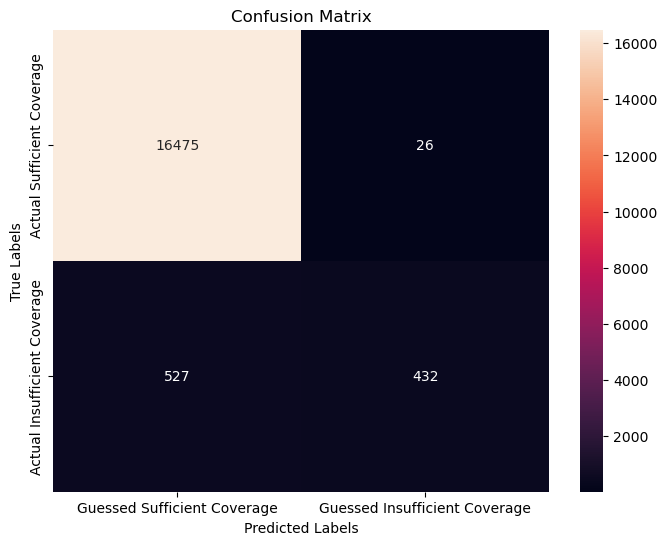

In [81]:
# Would it really feel like predictive modeling if we didn't create a heatmap of the confusion matrix?

plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Guessed Sufficient Coverage', 'Guessed Insufficient Coverage'], yticklabels = ['Actual Sufficient Coverage', 'Actual Insufficient Coverage'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix');

#### Interpretation
**True Negative (Top-Left):** Correctly predicted negative cases.
<br>
**False Positive (Top-Right):** Incorrectly predicted positive cases.
<br>
**False Negative (Bottom-Left):** Incorrectly predicted negative cases.
<br>
**True Positive (Bottom-Right):** Correctly predicted positive cases.

Based on the model above, we **accurately predicted 432 customers whose coverage is insufficient.** We missed 26 customers whose coverage is insufficient. And we overshot; 527 people's coverage is sufficient whom we predicted would not be.<br>
<br>
Can't say I'm not a little disappointed in these stats given the unrealistic advantage we had.

In [84]:
# Let's see if we can't display the 10 most important features to our model

# Access the RandomForestClassifier from the pipeline
rf_model = model.named_steps['classifier']

# Get feature importances from the RandomForestClassifier
importances = rf_model.feature_importances_

# Retrieve feature names from the preprocessor
# Numeric features (unaltered except for scaling)
numeric_feature_names = numeric_cols

# Categorical features (expanded due to one-hot encoding)
categorical_feature_names = model.named_steps['preprocessor'] \
    .named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)

# Combine all feature names
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Ensure lengths match
if len(all_feature_names) != len(importances):
    print(f"Mismatch: {len(all_feature_names)} feature names vs. {len(importances)} importances")

# Create a DataFrame for better visualization
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print(feature_importances.head(10))

Mismatch: 19779 feature names vs. 19778 importances


ValueError: All arrays must be of the same length

In [86]:
# LOL ok how long is my importances list

len(importances)

19778

In [88]:
# And all_feature_names ?

len(all_feature_names)

19779

In [90]:
# Let's transform X_train to inspect preprocessed data

X_transformed = model.named_steps['preprocessor'].transform(X_train)

# Check the shape of the transformed data
print(f"Shape of preprocessed data: {X_transformed.shape}")  # Should match len(importances)

C:\Users\natal\anaconda3\Lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['flood_characteristics_indicator']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Shape of preprocessed data: (69838, 19778)


In [92]:
# And get numeric and categorical feature names

numeric_feature_names = numeric_cols
categorical_feature_names = model.named_steps['preprocessor'] \
    .named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)

# Combine names and check length
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)
print(f"Total feature names: {len(all_feature_names)}")

Total feature names: 19779


In [94]:
# Now align the lengths by truncating feature names

# Side note, why do if statements still make me sweat like I'm going to throw an error?
# Who cares! Throw an error! Read it and learn!

if len(all_feature_names) > len(importances):
    all_feature_names = all_feature_names[:len(importances)]

# Create DataFrame for feature importances
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 features
print(feature_importances.head(10))

                              Feature  Importance
46            census_block_group_fips    0.098318
23             building_damage_amount    0.055507
26             contents_damage_amount    0.047566
15      amount_paid_on_building_claim    0.045897
24        net_building_payment_amount    0.043986
19  total_building_insurance_coverage    0.039143
16      amount_paid_on_contents_claim    0.032341
27        net_contents_payment_amount    0.031746
25            building_property_value    0.021446
20  total_contents_insurance_coverage    0.020710


In [96]:
# Interesting that census_block_group_fips is up there! You'd expect location to correlate with damage, but not necessarily with insufficient coverage.
# On the other hand, I remember from running this earlier that Lee County suffered such a disproportionate amount of damage, it's not surprising
# they'd also have more insufficient coverage just by virtue of exponentially more claims than other counties.

# Okay, back on track. What's the length of all_feature_names ?
len(all_feature_names)

19778

### Rerun Model After Debugging

In [98]:
# Create a DataFrame for feature importances

feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending = False)

# Display the top 10 important features
print("Top 10 Features by Importance:")
print(feature_importances.head(10))

Top 10 Features by Importance:
                              Feature  Importance
46            census_block_group_fips    0.098318
23             building_damage_amount    0.055507
26             contents_damage_amount    0.047566
15      amount_paid_on_building_claim    0.045897
24        net_building_payment_amount    0.043986
19  total_building_insurance_coverage    0.039143
16      amount_paid_on_contents_claim    0.032341
27        net_contents_payment_amount    0.031746
25            building_property_value    0.021446
20  total_contents_insurance_coverage    0.020710


<Figure size 1000x600 with 0 Axes>

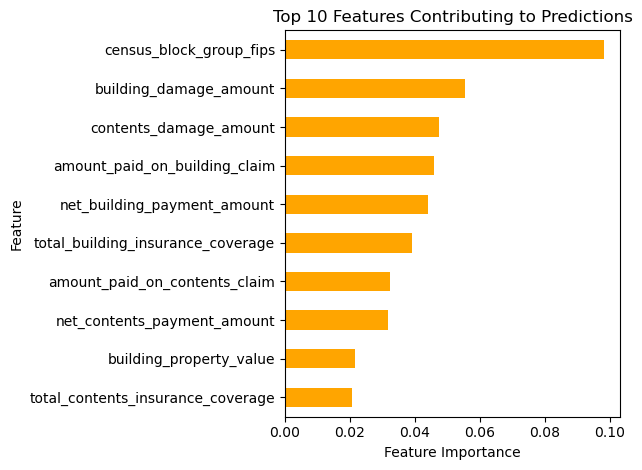

In [100]:
# Plot the top 10 features
top_n = 10
plt.figure(figsize=(10, 6))
feature_importances.head(top_n).plot(kind = 'barh', x  ='Feature', y = 'Importance', legend = False, color = 'orange')
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Features Contributing to Predictions')
plt.tight_layout();

In [102]:
nfip.shape

(87298, 71)

In [104]:
# I'm gonna be reckless and drop columns with >50% missing values. That can't help me predict things.

nfip = nfip.drop(columns = nfip.columns[nfip.isna().mean() > 0.5])
nfip.shape

(87298, 61)

In [108]:
# I guess it wasn't THAT reckless.
# Maybe I need to check for nulls. 

nfip.isnull().sum()

agriculture_structure_indicator           0
basement_enclosure_crawlspace_type    40740
policy_count                              0
crs_classification_code                2034
date_of_loss                              0
                                      ...  
total_coverage                            0
total_payment                             0
damage_diff_payment                       0
damage_diff_coverage                      0
coverage_insufficient                     0
Length: 61, dtype: int64

In [110]:
# Now let's define what the at-risk subset is.
atrisk = nfip[nfip['coverage_insufficient'] > 0]
atrisk.shape

(4795, 61)

In [112]:
# Count occurrences of each census_block_group_fips
fips_counts = atrisk['census_block_group_fips'].value_counts()

# Convert to DataFrame for easier analysis
fips_analysis = fips_counts.reset_index()
fips_analysis.columns = ['census_block_group_fips', 'count']

# Display the top 10 block groups
print("Top 10 Census Block Groups Associated with Insufficient Coverage:")
print(fips_analysis.head(10))

Top 10 Census Block Groups Associated with Insufficient Coverage:
   census_block_group_fips  count
0             1.200500e+11     72
1             1.207106e+11     54
2             1.207108e+11     52
3             1.207100e+11     51
4             1.207106e+11     50
5             1.207108e+11     48
6             1.207106e+11     46
7             1.207108e+11     45
8             1.207106e+11     41
9             1.207105e+11     40


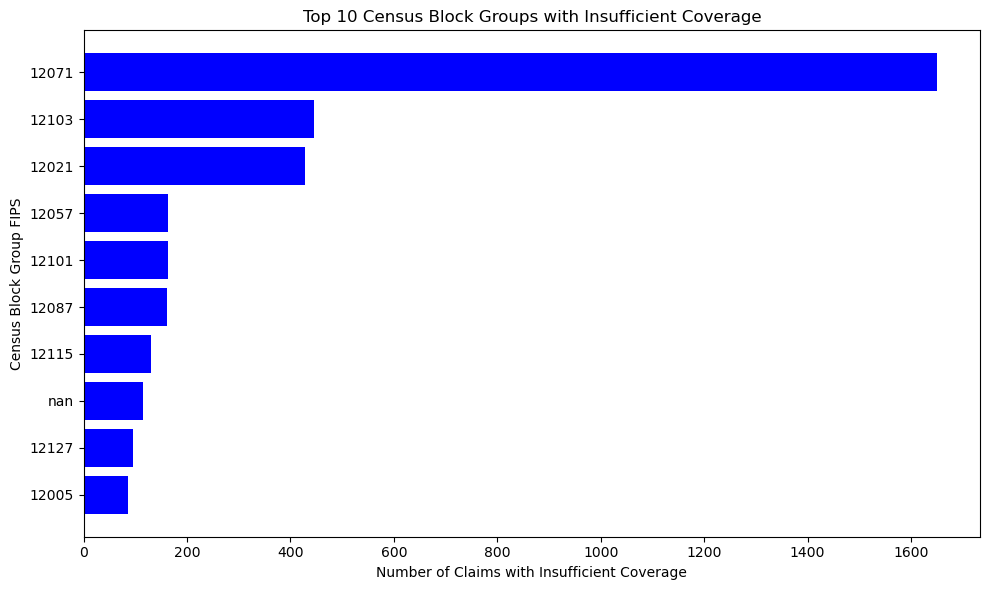

In [172]:
top_n = 10
top_fips = fips_analysis.head(top_n)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_fips['census_block_group_fips'], top_fips['count'], color = 'blue')
plt.gca().invert_yaxis()  # Highest count on top
plt.xlabel('Number of Claims with Insufficient Coverage')
plt.ylabel('Census Block Group FIPS')
plt.title(f'Top {top_n} Census Block Groups with Insufficient Coverage')
plt.tight_layout()
plt.show()

In [116]:
atrisk.to_csv('nfip_FL_at_risk_2025.02.04.csv', index = True)

In [114]:
# Gosh I love a blue horizontal bar graph. And 12071 is Lee County, no surprise there.

# Let's save the nfip dataset AND the atrisk one and move into Tableau.
# I forgot last time; I actually need an index in this dataset.

nfip.to_csv('nfip_florida_2025.02.04.csv', index = True)